<a href="https://colab.research.google.com/github/abderrazzaq-laanoui/PFE-HexaCoders/blob/main/ml_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align:center"><h1>RECONNAISSANCE DE L'ÉCRITURE MANUSCRITE DE LESTTRES TIFINAGH</h1></div>

---

# dépendances

#### Liaison avec Google Drive

In [1]:
# liaison avec  Google Drive comme source de donnees 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### importations

In [26]:
# Importation des bibliothèques
import os
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import random
import pickle
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import tensorflow as tf
from tensorflow import keras

#### Variables

In [3]:

CATEGORIES = ["ya", "yab", "yach", "yad", "yadd", "yae", "yaf", "yag", "yagh", 
              "yagw", "yah", "yahh", "yaj", "yak", "yakw", "yal", "yam", "yan", 
              "yaq", "yar","yarr", "yas", "yass", "yat", "yatt", "yaw", "yax", 
              "yay", "yaz", "yazz", "yey", "yi", "yu"] # a list of all possible classes
T_CATEGORIES = ['ⴰ', 'ⴱ', 'ⵛ', 'ⴷ', 'ⴹ', 'ⵄ', 'ⴼ', 'ⴳ', 'ⵖ', 'ⴳⵯ', 'ⵀ', 'ⵃ', 'ⵊ', 'ⴽ', 'ⴽⵯ',
                'ⵍ','ⵎ','ⵏ', 'ⵇ', 'ⵔ', 'ⵕ', 'ⵙ', 'ⵚ', 'ⵜ', 'ⵟ', 'ⵡ', 'ⵅ', 'ⵢ', 'ⵣ','ⵥ', 'ⴻ', 'ⵉ', 'ⵓ']

training_data = [] # cette liste qui contiendra les données d'entraînement traitées
testing_data = [] # cette liste qui contiendra les données de test traitées

In [ ]:
for i in range(33):
    print(CATEGORIES[i] + ' => ' + T_CATEGORIES[i])

ya => ⴰ
yab => ⴱ
yach => ⵛ
yad => ⴷ
yadd => ⴹ
yae => ⵄ
yaf => ⴼ
yag => ⴳ
yagh => ⵖ
yagw => ⴳⵯ
yah => ⵀ
yahh => ⵃ
yaj => ⵊ
yak => ⴽ
yakw => ⴽⵯ
yal => ⵍ
yam => ⵎ
yan => ⵏ
yaq => ⵇ
yar => ⵔ
yarr => ⵕ
yas => ⵙ
yass => ⵚ
yat => ⵜ
yatt => ⵟ
yaw => ⵡ
yax => ⵅ
yay => ⵢ
yaz => ⵣ
yazz => ⵥ
yey => ⴻ
yi => ⵉ
yu => ⵓ



# CHARGEMENT DU DATASET

In [4]:

#@markdown \
#@markdown #### Entrez le chemin d'accès au répertoire DATASET dans votre Drive:
chemin = "" #@param {type:"string"}
#@markdown \

if chemin == "":
    chemin = "genie info/Rapport PFE - HexaCoders/DATASET" #default path
# Declaration des Variables
DIR = os.path.join("/content/drive/MyDrive",chemin) # h the path to the DATASET dir  in your drive
TRAIN_DATA_DIR = os.path.join(DIR,"training_data/")
TEST_DATA_DIR = os.path.join(DIR,"testing_data/")
MODEL_DIR = os.path.join(DIR,"model/")
TRAIN_MODEL_DIR = os.path.join(DIR,"model/train/")
TEST_MODEL_DIR = os.path.join(DIR,"model/test/")



## DONNÉES D'ENTRAÎNEMENT


#### Préparation des données

<b>OpenCV</b> (référencé par cv) est une bibliothèque multi-plateforme qui nous permet de développer des applications de vision par ordinateur en temps réel. Elle se concentre principalement sur le traitement des images en temps réel., la capture et l'analyse vidéo, y compris des fonctionnalités telles que la détection des visages et des objets.

In [ ]:
training_data = [] # la liste qui contiendra les données d'entraînement traitées
def prepare_training_data():
    for category in CATEGORIES :
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)  # obtention du classement (0 à 32)
        for img in os.listdir(path): # itérer sur chaque image dans un dossier de caractères
            img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE) # read graysacled images
            new_array = cv.resize(img_array, (50,50)) # redimensionnement des images
            training_data.append([new_array, class_num]) # append processed image to the training data list

prepare_training_data() # calling the fct

In [ ]:
testing_data = [] # a list that will contain processed testing data
def prepare_testing_data():
    for category in CATEGORIES :
        path = os.path.join(TEST_DATA_DIR, category)
        class_num = CATEGORIES.index(category)  # get the classification  (0 to 32)
        for img in os.listdir(path): # iterate over each image in a caracter folder 
            img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE) # read graysacled images
            new_array = cv.resize(img_array, (50,50)) # resizing images
            testing_data.append([new_array, class_num]) # append processed image to the testing data list

prepare_testing_data() # calling the fct

Nous voulons mélanger les données. Pour l'instant, nos données sont sous forme de : "ya,"yab", puis "yach" ... . Cela finit généralement par causer des problèmes, car, au début, le classificateur apprendra à prédire toujours "ya". Ensuite, il passera à prédire "yab" ...

In [ ]:
# shuffle the  data randomly 
# random.shuffle(training_data)
random.shuffle(testing_data)


#### Création du modèle

In [5]:
# Créer le modèle
x_train = [] 
y_train = []

for features,label in training_data:
    x_train.append(features)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [6]:
# Créer le modèle
x_test = [] 
y_test = []

for features,label in testing_data:
    x_test.append(features)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)


#### Sauvegarde du modèle

Le module <b> pickle </b> met en œuvre des protocoles binaires pour sérialiser et désérialiser une structure d'objet Python. <br><br> Le "pickling" est le processus par lequel une hiérarchie d'objets Python est convertie en un flux d'octets.

In [ ]:

# Sauvegarder le modèle

pickle_out = open(TRAIN_MODEL_DIR + "x_train.pickle","wb")
pickle.dump(x_train, pickle_out)
pickle_out.close()

pickle_out = open(TRAIN_MODEL_DIR + "y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

In [ ]:
# Sauvegarder le modèle

pickle_out = open(TEST_MODEL_DIR + "x_test.pickle","wb")
pickle.dump(x_test, pickle_out)
pickle_out.close()

pickle_out = open(TEST_MODEL_DIR + "y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()


#### Téléchargement du modèle

Le "unpickling" est l'opération inverse, par laquelle un flux d'octets (provenant d'un fichier binaire ou d'un objet de type octet) est reconverti en une hiérarchie d'objets.

In [7]:
# to load the model we use the script
pickle_in = open(TRAIN_MODEL_DIR + "x_train.pickle","rb")
x_train = pickle.load(pickle_in)

pickle_in = open(TRAIN_MODEL_DIR + "y_train.pickle","rb")
y_train = pickle.load(pickle_in)

In [8]:
# to load the model we use the script
pickle_in = open(TEST_MODEL_DIR + "x_test.pickle","rb")
x_test = pickle.load(pickle_in)

pickle_in = open(TEST_MODEL_DIR + "y_test.pickle","rb")
y_test = pickle.load(pickle_in)

# CRÉER LE RÉSEAU NURAL CONVOLUTIONNEL

#### Helper-function for plotting images


In [9]:
def plot_image(image, cls_true, cls_pred=None):

    plt.imshow(image.reshape(img_shape), cmap='gray')
    
    # Show true and predicted classes.
    if cls_pred is None:
        plt.figtext(.5,0,"True: {0}".format(T_CATEGORIES[cls_true]), fontsize=14, ha='center')
    else:
          plt.figtext(.5,0, "True: {0}, Pred: {1}".format(T_CATEGORIES[cls_true], T_CATEGORIES[cls_pred]), fontsize=14, ha='center')
        
    plt.axis('off')

    plt.show()

#### CNN Configurations 

#### Dimensions de Donnees pour plus de commodité

In [11]:
# The number of pixels in each dimension of an image.
img_size = 50

# The images are stored in one-dimensional arrays of this length.
img_size_flat = 50*50

# Tuple with height and width of images used to reshape arrays.
img_shape = (50, 50)

# Number of classes, one class for each of 33 alphabet.
num_classes = 33

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1


#### Structuration des entrées

In [19]:
# to reduce the computition we convert the numbers from float64 => float32
# we normalise (deviding all by 255.0) to make numbers between 0 => 1 instead of 0 => 255
x_train = x_train.reshape(-1,50,50,1).astype("float32") / 255.0 
x_test = x_test.reshape(-1,50,50,1).astype("float32") / 255.0

y_train = keras.utils.to_categorical(y_train, 33)
y_test = keras.utils.to_categorical(y_test, 33)


#### CREATE THE VGG16 MODEL

In [11]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

def VGG16(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		#model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.40))

		# (CONV => RELU) * 3 => POOL layer set
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.40))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [12]:
model = VGG16(width=50, height=50, depth=1, classes=33)

In [13]:
# and batch size
INIT_LR = 0.01
EPOCHS = 50
BS = 16
print("Model info... \n ")
print(model.summary())

Model info... 
 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25,

In [14]:
print("[INFO] training network...")
opt = keras.optimizers.Adam(lr= INIT_LR, decay= INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] training network...


In [16]:
tf.config.run_functions_eagerly(True)

In [17]:
# train the network + monitor
H = model.fit(x=x_train, y=keras.utils.to_categorical(y_train, 33), batch_size=BS,
              validation_data=(x_test, keras.utils.to_categorical(y_test, 33)), 
              steps_per_epoch= len(y_train) // BS, epochs=EPOCHS)
print("[INFO] training Done...")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
1443/1443 [==============================] - 55s 34ms/step - loss: 1.1120 - accuracy: 0.7289 - val_loss: 0.3330 - val_accuracy: 0.9034
Epoch 2/50
1443/1443 [==============================] - 49s 34ms/step - loss: 0.1978 - accuracy: 0.9437 - val_loss: 0.0971 - val_accuracy: 0.9803
Epoch 3/50
1443/1443 [==============================] - 49s 34ms/step - loss: 0.1078 - accuracy: 0.9688 - val_loss: 0.0591 - val_accuracy: 0.9845
Epoch 4/50
1443/1443 [==============================] - 49s 34ms/step - loss: 0.1053 - accuracy: 0.9710 - val_loss: 0.2705 - val_accuracy: 0.9148
Epoch 5/50
1443/1443 [==============================] - 49s 34ms/step - loss: 0.0797 - accuracy: 0.9774 - val_loss: 0.0435 - val_accuracy: 0.9913
Epoch 6/50
1443/1443 [==============================] - 49s 34ms/step - loss: 0.0683 - accuracy: 0.9813 - val_loss: 0.0418 - val_accuracy: 0.9932
Epoch 7/50
1443/1443 [==============================] - 49s 34ms/step - loss: 0.0597 - accuracy: 0.9837 - val_loss: 0.0627 -

In [20]:
scores = model.evaluate (x_test, y_test, verbose=0)
print("Accuracy = "+str(scores[1]*100)+" \n")


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Accuracy = 99.65909123420715 



In [ ]:
# evaluate the network
print("Evaluation... : ")
predictions = model.predict(x_test, batch_size=BS)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))


In [ ]:

# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save("vggnet_256.model")
f = open("smallvggnet_lb_256.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

scores= model.evaluate (x_test, y_test, verbose=0)
print("Accuracy = "+str(scores[1]*100)+" \n")




# ploting confision matrix

y_pred = model.predict_classes(testX)
testY_mat=np.argmax(testY, axis=1)

class_names = list(lb.classes_)

font = {
    'family': 'Times New Roman',
    'size': 12
}

matplotlib.rc('font', **font)

mat = confusion_matrix(testY_mat, y_pred)
plt.figure()
plot_confusion_matrix(conf_mat=mat, figsize=(12, 12), class_names = class_names, show_normed=False)
plt.savefig("conf_mat_256.png")
print("Ploting Conf_Mat..................")


# plot the training loss 
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Loss: VGG_Net (By Mounir And Ibrahim) ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss_plot_256.png")

# plot the training accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc") 
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy: VGG_Net (By Mounir And Ibrahim) ")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy_plot_256.png")


# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save("vggnet_256.model")
f = open("smallvggnet_lb_256.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()


print("Done Successfully...")

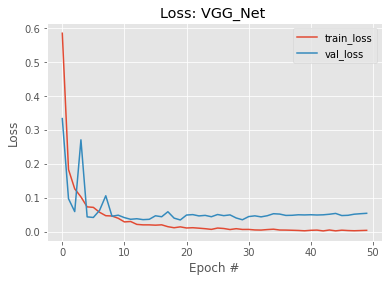

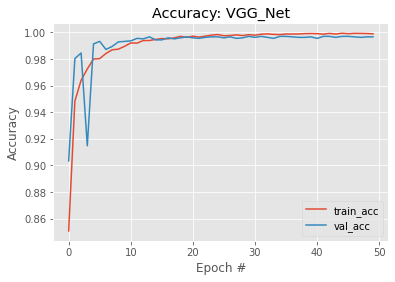

In [22]:
# plot the training loss 
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Loss: VGG_Net ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss_plot_256.png")

# plot the training accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc") 
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy: VGG_Net")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy_plot_256.png")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font fam

FileNotFoundError: ignored

<Figure size 432x288 with 0 Axes>

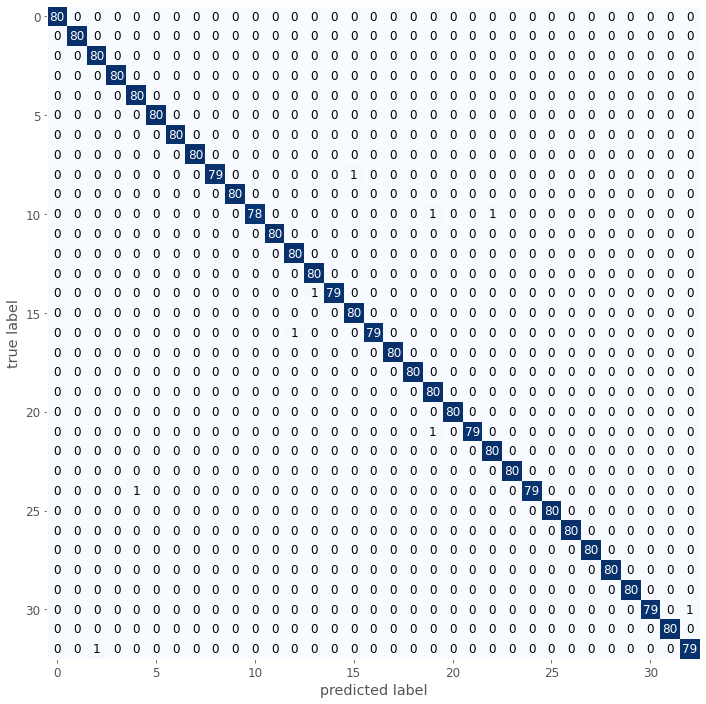

In [27]:
# ploting confision matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict_classes(x_test)
y_test_mat=np.argmax(y_test, axis=1)

My_classes = T_CATEGORIES

font = {
    'family': 'Times New Roman',
    'size': 12
}

matplotlib.rc('font', **font)

mat = confusion_matrix(y_test_mat, y_pred)
plt.figure()
plot_confusion_matrix(conf_mat=mat, figsize=(12, 12), show_normed=False)
plt.savefig("output/conf_mat.png")
print("Ploting Conf_Mat..................")